# Notebook para desenvolvimento do meétodo Kmeans e DBscan para o projeto 1 de Machine learning
 
# Desenvolvido por Felipe Arruda (RA: 196862) e Leonardo Koike (RA: 201332)

# 2021

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import Dict, Callable

In [2]:
def initializer(data: np.ndarray, k_cluster: int) -> np.ndarray:
    """Método para inicializar o kmeans. Aqui seguimos a estratégia do algoritmo Random partition.
    Args:
        data (np.ndarray) : array com os dados a serem analisados
        k_cluster (int) : inteiro com o número de cluster
    Return:
        centers_cluster (np.ndarray) : array com as informações dos centroides dos cluster
    """
    # instancia do dicionario
    set_centroids = {}
    # embaralho os dados para ter uma sequencia aleatoria
    np.random.shuffle(data)
    div = data.shape[0]//k_cluster
    # instancia do array para conter o valor dos centroides dos cluster
    centers_cluster = np.ndarray((k_cluster,data.shape[1]))
    # agrupo os dados em cluster aleatórios
    for index in range(k_cluster):
        set_centroids[index] = data[index*div:(index+1)*div,:]
    # tiro o valor médio de cada cluster para obter o centroide
    for idx,value in set_centroids.items():
        centers_cluster[idx] = np.mean(value,axis=0)
    return centers_cluster

In [3]:
def k_means(data: np.ndarray, k_clusters_centers: int) -> np.ndarray:
    """Método de aprendizagem não supervisionado. Através dos dados, o programa aprende a dividir os dados em clusters, definindo um centro para esses clusters.
    Args:
        data (np.ndarray) : Dados que serão utilizados para serem dividos em cluster
        k_cluster_centers (int) : quantidade de cluster
    Return:
        set_centroids (np.ndarray) : array com a posição (coordenada) do centro de cada cluster
    """
    dim = data.shape[1]
    num = data.shape[0]
    # INITIALIZATION
    # Random partition como a inicialização do kmeans, aqui temos ja valores de centroides para os clusters
    list_centroids = initializer(data=data,k_cluster=k_clusters_centers)
    flag = True
    iter = 0
    # LEARNING PART
    # Loop de aprendizagem
    while flag:
        # crio um array para o novo valor de centroide
        new_centroids = np.ndarray((k_clusters_centers,dim))
        # divido os dados entre os cluster. Crio um dicionario com o conjunto dos pontos de cada cluster
        set_centroids = assign_to_cluster(data_in=data,center_cluster=list_centroids)
        # para cada cluster, calculo o novo valor de centroide que é a media dos pontos nesse cluster
        for idx,value in set_centroids.items():
            if value.size == 0:
                pass
            else:
                new_centroids[idx] = np.mean(value,axis=0)
        # verifico se o loop terminou: se as coordenadas do centroides são os mesmos da iteração passada ou se batemos 30 iterações
        if np.all(list_centroids==new_centroids) or iter == 30:
            flag = False
        # se o loop continua, list_centroids recebe o array com os novos valores de centroides e incremento o valor da iteração.
        else:
            list_centroids = new_centroids
            iter += 1
    return new_centroids

In [4]:
def assign_to_cluster(data_in: np.ndarray, center_cluster: np.ndarray) -> Dict[int,np.ndarray]:
    """ Com a posição dos centroides dos cluster fornecidos, cada ponto é relacionado a um cluster segundo a sua distancia euclidiana a esses centroides. A menor distancia significa que o ponto pertence a esse mesmo cluster.
    Args:
        data_in (np.ndarray) : Dados que serão dividos em clusters
        center_cluster (np.ndarray) : Array com a posição dos centroides dos clusters
    Return:
        set_centroids (Dict[int,np.ndarray]) : dicionário relacionando cada cluster com um array dos pontos que pertencem a ele
    """
    # instancia de um dicionario que relaciona cada cluster com os pontos que pertecem a ele
    set_centroids={}
    # para cada cluster, instancio uma lista
    for i in range(center_cluster.shape[0]):
        set_centroids[i] = []
    # garanto que o numero de features é a mesma
    assert center_cluster.shape[1] == data_in.shape[1]
    # para cada dado, verifico qual o centroide mais próximo
    for element in data_in:
        # array com todas as distancias dos centroides
        dist = np.linalg.norm(center_cluster-element,axis=1)
        # esse dado é adicionado ao cluster cujo centroide é o mais próximo
        set_centroids[np.argmin(dist)].append(element.tolist())
    # no final da função, converto a lista em um array numpy
    for center,value in set_centroids.items():
        set_centroids[center] = np.array(value)
    return set_centroids

In [5]:
def elbow(fun1: Callable, data: np.ndarray) ->  np.ndarray:
    """ Função de elbow que teste e plota um gráfico mostrando qual o melhor valor de k para a solução
    Args:
        fun1 (Callable): função a ser testada, irá retornar o valor dos centroides dos cluster 
    Return:
        set_centroids (Dict[int,np.ndarray]) : dicionário relacionando cada cluster com um array dos pontos que pertencem a ele
    """
    # Número máximo de cluster para ser testado
    MAX_K_CLUSTER = 10
    # crio uma array com o somatório do quadrado dos erros
    sse = np.ndarray((MAX_K_CLUSTER,1))
    # testo de 1 a 9 cluster na entrada da função 
    for i in range(1,MAX_K_CLUSTER):
        center_cluster = fun1(data,i)
        # divido o conjunto de dados nos cluster
        set_centroids = assign_to_cluster(data_in=data,center_cluster=center_cluster)
        # inicio o valor do erro em 0
        sse[i] = 0
        # e vou incrementando o valor do quadrado do erro entre o centroide e os pontos desse cluster
        for index,value in set_centroids.items():
            if value.size == 0:
                pass
            else:
                sse[i] += np.sum(np.linalg.norm(value-center_cluster[index],axis=1)**2)
    # ploto o gráfico representativo para analisar qual o melhor valor de k para o problema
    plt.plot(range(1,MAX_K_CLUSTER),sse[1:,:],'ro-')
    plt.xlabel("Quantidade de cluster para o algoritmo k_means")
    plt.ylabel("SSE - Sum of squared error")
    plt.title("Função Elbow")
    plt.show()
    # retorno esse array com a soma do quadrado do erro para cada valor de k.
    return sse[1:,:]

In [25]:
MAX = 1000000000000000
def dunn_index(fun1: Callable, data: np.ndarray) -> np.ndarray:
    # Número máximo de cluster para ser testado
    MAX_K_CLUSTER = 10
    dunn_index = np.ndarray((MAX_K_CLUSTER,1))
    max_d = 0
    min_d = MAX
    for k in range(2,MAX_K_CLUSTER):
        center_cluster = fun1(data,k)
        set_centroids = assign_to_cluster(data_in=data,center_cluster=center_cluster)
        for index, value in set_centroids.items():
            if value.size > 0:
                max_d = max(max_d,max_inner_dist(value))
                aux = index+1
                while(aux!=k):
                    if set_centroids[aux].size>0:
                        min_d = min(min_d,min_dist_cluster(value,set_centroids[aux]))
                    aux += 1
        dunn_index[k] = min_d/max_d
    # ploto o gráfico representativo para analisar 
    plt.plot(range(2,MAX_K_CLUSTER),dunn_index[2:,:],'bo-')
    plt.xlabel("Quantidade de cluster para o algoritmo")
    plt.ylabel("Dunn index")
    plt.title("Gráfico de Dunn index")
    plt.show()
    return dunn_index[2:,:]

def max_inner_dist(data: np.ndarray) -> float:
    max_dist = 0
    for point in data:
        max_dist = max(max_dist,np.max(np.linalg.norm(data-point,axis=1)))
    return max_dist

def min_dist_cluster(cluster1: np.ndarray, cluster2: np.ndarray) -> float:
    min_dist = MAX
    for point in cluster1:
        min_dist = min(min_dist,np.min(np.linalg.norm(cluster2-point,axis=1)))
    return min_dist

In [26]:
def run_and_plot_training(data: np.ndarray, k: int,) -> np.ndarray:
    """ Função que roda o algoritmo do kmeans para os dados de treinamento e plota o gráfico representativo.
    Args:
        data (np.ndarray) : Dados que serão utilizados para rodar o kmeans
        k (int) : Quantidade de cluster
    Return:
        cluster_centers (np.ndarray) : centros dos clusters
    """
    # função k_means em execução, obtenho um array com o centro dos cluster
    cluster_centers = k_means(data=data,k_clusters_centers=k)
    # array de cores para plotar os resultados
    colors = cm.rainbow(np.linspace(0,1,cluster_centers.shape[0]))
    # função assign_to_cluster em execução, obtenho um dicionario que aponta para cada cluster, um array dos pontos que pertecem a esse cluster
    set_clusters = assign_to_cluster(data_in=data,center_cluster=cluster_centers)
    # Plot dos pontos obtidos, dividindo os pontos em suas cores 
    for value,color in zip(set_clusters.values(),colors):
        if(value.size!=0):
            plt.scatter(value[:,0],value[:,1],marker='.',color=color)
    plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X')
    plt.title("Dados de treinamento do algoritmo Kmeans e seus clusters")
    plt.show()
    return cluster_centers

In [27]:
def run_and_plot_testing(data: np.ndarray, cluster_centers: np.ndarray) -> None:
    """ Função que associa cada dado de teste ao seu devido cluster, com base nos centroides dos cluster fornecidos, e plota o gráfico representativo.
    Args:
        data (np.ndarray) : Dados de teste que serão dividos nos clusters
        cluster_centers (np.ndarray) : centros dos clusters
    Return:
        None: nada
    """
    # array de cores para plotar o resultado
    colors = cm.rainbow(np.linspace(0,1,cluster_centers.shape[0]))
    # associa os dados de testes ao cluster
    set_clusters_test = assign_to_cluster(data_in=data,center_cluster=cluster_centers)
    # plot dos pontos de acordo com o seu cluster
    for value,color in zip(set_clusters_test.values(),colors):
        if value.size != 0:
            plt.scatter(value[:,0],value[:,1],marker='>',color=color)
    plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X')
    plt.title("Dados de teste do algoritmo Kmeans e seus clusters")
    plt.show()

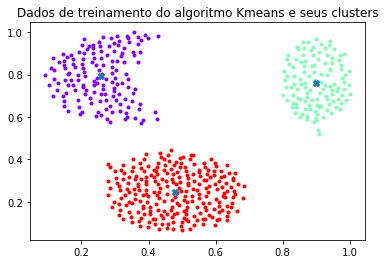

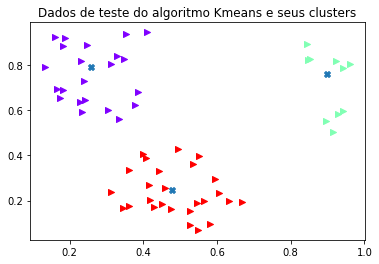

In [28]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)
# divisão para dados de treinamento e dados de teste
np.random.shuffle(data_norm)
train_index = int(data_norm.shape[0]*0.9)
train_data,test_data = np.vsplit(data_norm,[train_index])

# roda o kmeans com os dados de treino e retorna um array com os centroids
res = run_and_plot_training(data=train_data,k=3)
# roda e atribui cada dado de teste ao seu cluster
run_and_plot_testing(data=test_data,cluster_centers=res)

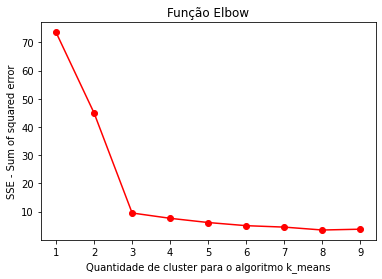

array([[73.54981835],
       [44.95179509],
       [ 9.52971983],
       [ 7.64965874],
       [ 6.15384733],
       [ 5.03988097],
       [ 4.52824942],
       [ 3.50319913],
       [ 3.79255081]])

In [29]:
elbow(fun1=k_means,data=train_data)

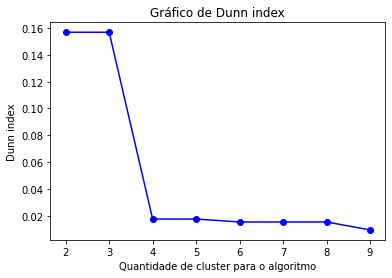

array([[0.1568882 ],
       [0.1568882 ],
       [0.01751066],
       [0.01751066],
       [0.01533628],
       [0.01533628],
       [0.01533628],
       [0.00939817]])

In [30]:
dunn_index(fun1=k_means,data=train_data)